In [2]:
import os

import scanpy as sc
import numpy as np
import pandas as pd
import torch
from anndata import AnnData
import seaborn as sns
import matplotlib.pyplot as plt

import scSLAT
from scSLAT.model import Cal_Spatial_Net, load_anndatas, run_SLAT, scanpy_workflow, spatial_match
from scSLAT.viz import match_3D_multi, hist, match_3D_celltype, Sankey
from scSLAT.metrics import region_statistics

In [2]:
sc.set_figure_params(dpi=300, dpi_save=300, transparent=True, facecolor=(1,1,1,1))

In [3]:
adata1_filter = sc.read_h5ad('./seqFISH_filer.h5ad')
adata2 = sc.read_h5ad('./Stereo_filer.h5ad')

In [4]:
# sc.pl.spatial(adata1_filter, spot_size=0.03, color='celltype_mapped_refined')
# sc.pl.spatial(adata2, spot_size=1, color='annotation')

In [5]:
Cal_Spatial_Net(adata1_filter, k_cutoff=50, model='KNN')
Cal_Spatial_Net(adata2, k_cutoff=25, model='KNN')

Calculating spatial neighbor graph ...
The graph contains 642647 edges, 11529 cells.
55.741781594240614 neighbors per cell on average.
Calculating spatial neighbor graph ...
The graph contains 132251 edges, 5031 cells.
26.287219240707614 neighbors per cell on average.


In [6]:
edges, features = load_anndatas([adata1_filter, adata2], feature='DPCA', singular=True)

Use DPCA feature to format graph


/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/rd2/user/xiacr/SLAT/scSLAT/model/preprocess.py:89: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata.layers["counts"] = adata.X.copy()
/rd2/user/xiacr/SLAT/scSLAT/model/preprocess.py:89: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X

In [7]:
adata1_filter.obsm['X_dpca'] = features[0].numpy()
adata2.obsm['X_dpca'] = features[1].numpy()

/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatte

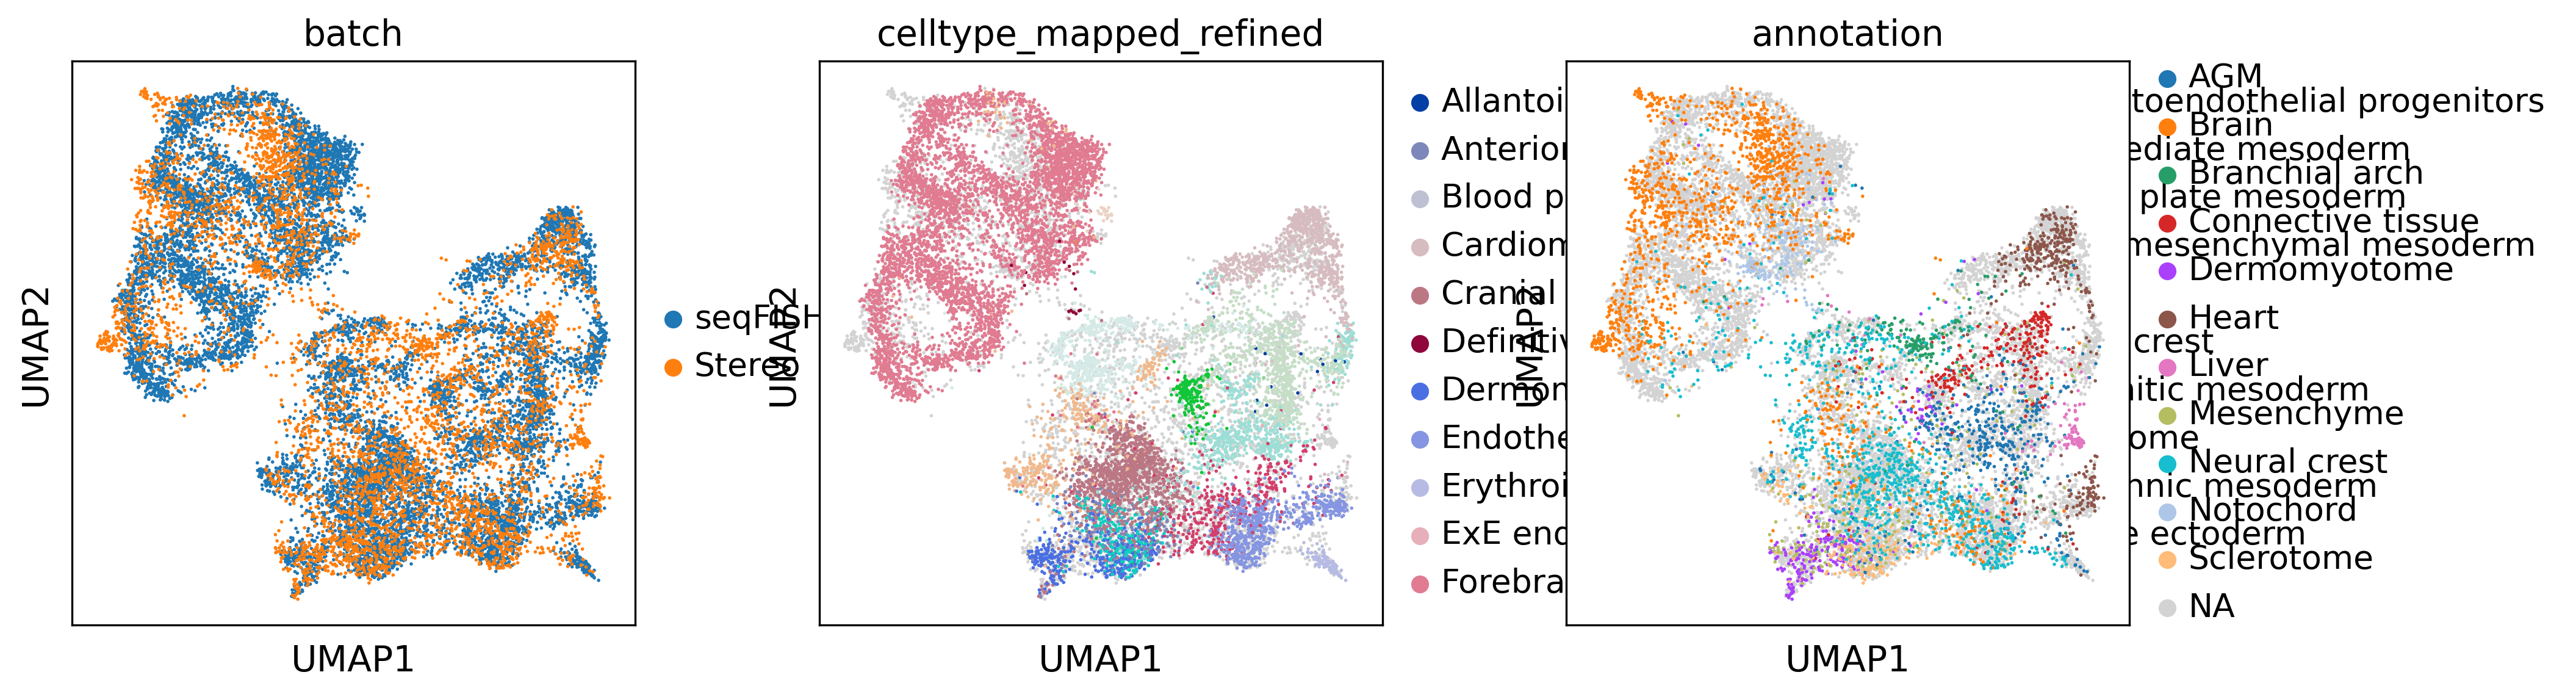

In [7]:
adata = adata1_filter.concatenate(adata2, batch_key='batch', batch_categories=['seqFISH', 'Stereo'])
sc.pp.neighbors(adata, use_rep='X_dpca', n_neighbors=20, knn=True)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch', 'celltype_mapped_refined', 'annotation'])

# Run adata1_filterSLAT

In [8]:
embd0, embd1, time = run_SLAT(features, edges, LGCN_layer=6, epochs=7, anchor_scale=0.7, batch_d_per_iter=7)

Choose GPU:6 as device
Running
---------- epochs: 1 ----------
---------- epochs: 2 ----------
---------- epochs: 3 ----------
---------- epochs: 4 ----------
---------- epochs: 5 ----------
---------- epochs: 6 ----------
---------- epochs: 7 ----------
Training model time: 1.90


0.400~0.450        66          1.312%
0.450~0.500       195          3.876%
0.500~0.550       382          7.593%
0.550~0.600       530         10.535%
0.600~0.650       585         11.628%
0.650~0.700       620         12.324%
0.700~0.750       665         13.218%
0.750~0.800       722         14.351%
0.800~0.850       783         15.564%
0.850~0.900       402          7.990%
0.900~0.950        67          1.332%
0.950~1.000         0          0.000%


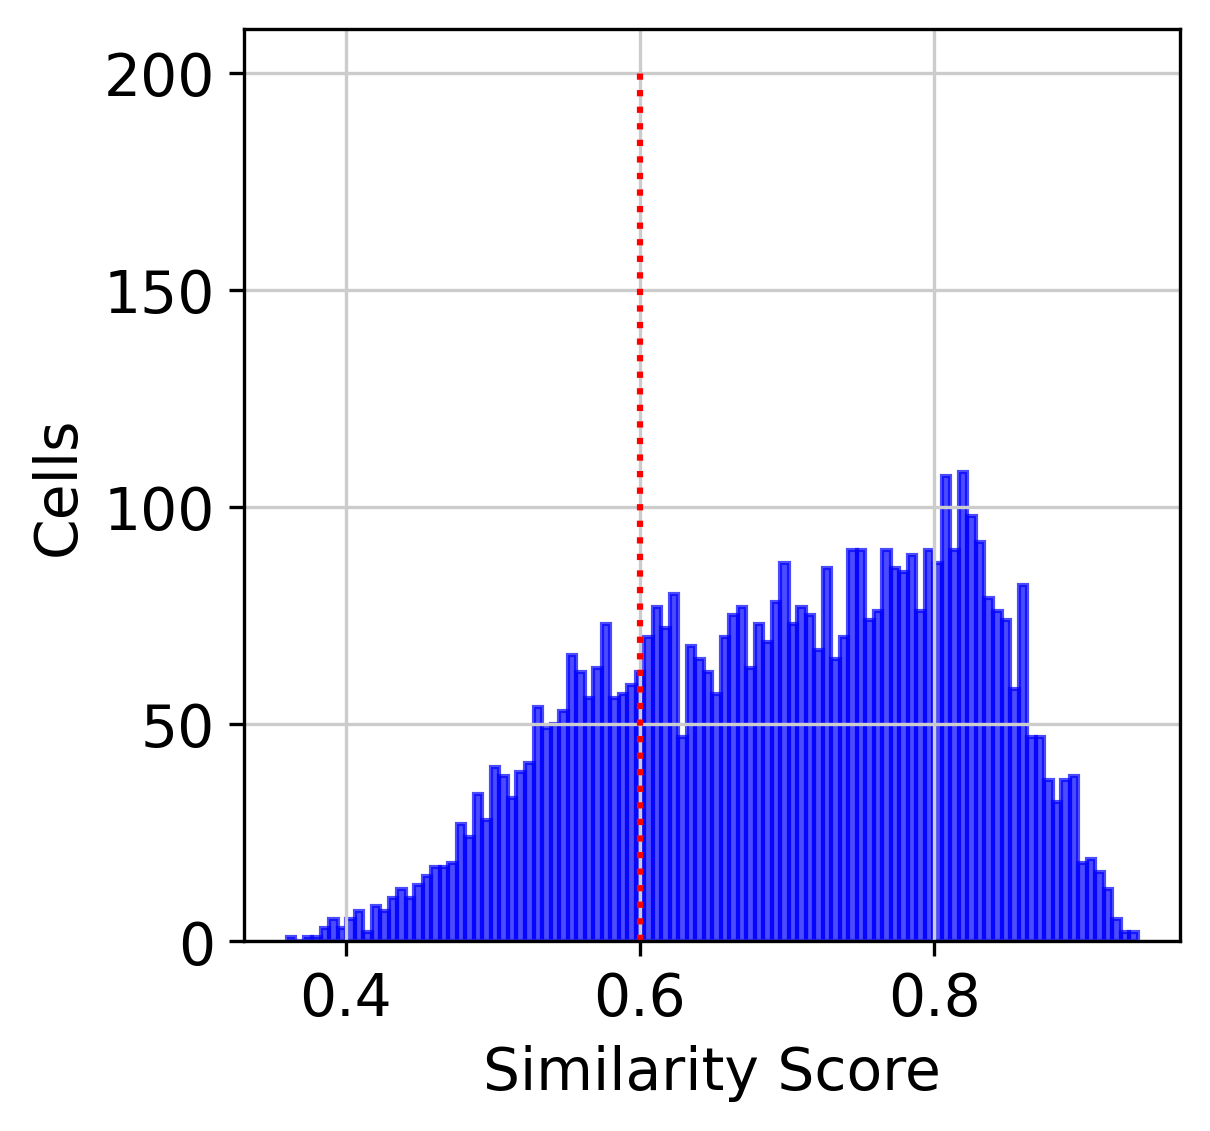

In [9]:
best, index, distance = spatial_match([embd0, embd1], adatas=[adata1_filter,adata2], top_n=50)
adata1_df = pd.DataFrame({'index':range(adata1_filter.shape[0]),
                          'x': adata1_filter.obsm['spatial'][:,0],
                          'y': adata1_filter.obsm['spatial'][:,1],
                          'celltype':adata1_filter.obs['celltype_mapped_refined'],
                          'Wnt3a':sc.get.obs_df(adata1_filter,'Wnt3a')})
adata2_df = pd.DataFrame({'index':range(adata2.shape[0]),
                          'x': adata2.obsm['spatial'][:,0],
                          'y': adata2.obsm['spatial'][:,1],
                          'celltype':adata2.obs['annotation'],
                          'Wnt3a':sc.get.obs_df(adata2,'Wnt3a')})

matching = np.array([range(index.shape[0]), best])
best_match = distance[:,0]
region_statistics(best_match, start=0.4, number_of_interval=12)
hist(best_match, cut=0.6)

/rd2/user/xiacr/SLAT/scSLAT/viz/multi_dataset.py:242: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



dataset1: 21 cell types; dataset2: 11 cell types; 
                    Total :29 celltypes; Overlap: 3 cell types 
                    Not overlap :[['Endothelium', 'Intermediate mesoderm', 'ExE endoderm', 'Blood progenitors', 'Cranial mesoderm', 'Mixed mesenchymal mesoderm', 'Lateral plate mesoderm', 'Anterior somitic tissues', 'Erythroid', 'Splanchnic mesoderm', 'Definitive endoderm', 'Forebrain/Midbrain/Hindbrain', 'Presomitic mesoderm', 'Cardiomyocytes', 'Allantois', 'NMP', 'Haematoendothelial progenitors', 'Surface ectoderm', 'Notochord', 'Mesenchyme', 'AGM', 'Liver', 'Connective tissue', 'Brain', 'Heart', 'Branchial arch']]
Subsample 300 cell pairs from 5031


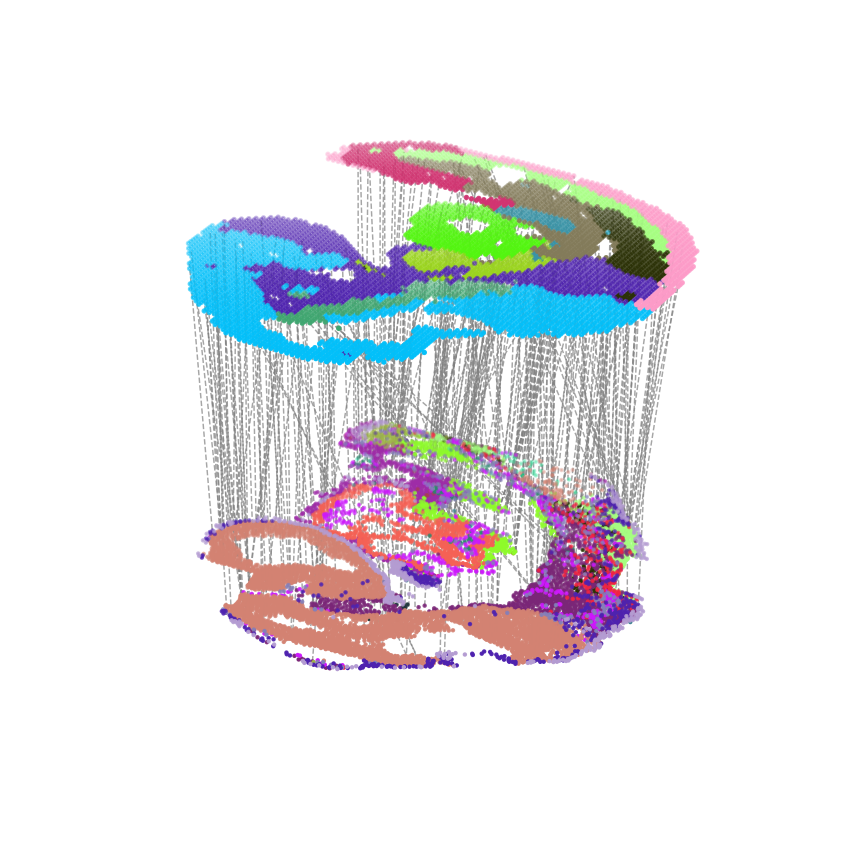

In [25]:
multi_align = match_3D_multi(adata1_df, adata2_df, matching, meta='celltype',
                             scale_coordinate=True, subsample_size=300, exchange_xy=False)

multi_align.draw_3D(size=[7, 8], line_width=0.7, line_color='grey', point_size=[1.25,2.5], 
                    hide_axis=True, show_error=False, save='./Alignment.png')

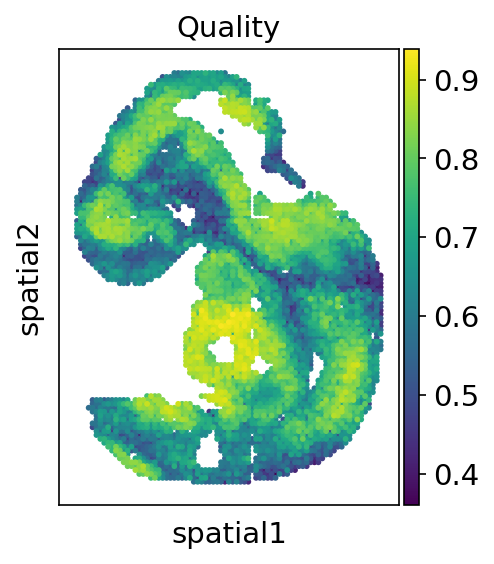

In [17]:
%matplotlib inline
adata2.obs['low_quality_index']= best_match 
adata2.obs['low_quality_index'] = adata2.obs['low_quality_index'].astype(float)
sc.pl.spatial(adata2, color='low_quality_index', spot_size=1.5, title='Quality')

In [13]:
# matching_filter = matching[:, best_match > 0.8]
adata2_df['target_celltype'] = adata1_df.iloc[matching[1,:],:]['celltype'].to_list()
matching_table = adata2_df.groupby(['celltype','target_celltype']).size().unstack(fill_value=0)
matching_table = matching_table.loc[:, matching_table.columns != 'Low quality']

In [17]:
Sankey(matching_table, prefix=['seqFISH', 'Stereo-seq'])

/rd2/user/xiacr/SLAT/scSLAT/viz/multi_dataset.py:242: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



dataset1: 21 cell types; dataset2: 11 cell types; 
                    Total :29 celltypes; Overlap: 3 cell types 
                    Not overlap :[['Endothelium', 'Intermediate mesoderm', 'ExE endoderm', 'Blood progenitors', 'Cranial mesoderm', 'Mixed mesenchymal mesoderm', 'Lateral plate mesoderm', 'Anterior somitic tissues', 'Erythroid', 'Splanchnic mesoderm', 'Definitive endoderm', 'Forebrain/Midbrain/Hindbrain', 'Presomitic mesoderm', 'Cardiomyocytes', 'Allantois', 'NMP', 'Haematoendothelial progenitors', 'Surface ectoderm', 'Notochord', 'Mesenchyme', 'AGM', 'Liver', 'Connective tissue', 'Brain', 'Heart', 'Branchial arch']]
Subsample 2639 cell pairs from 2639


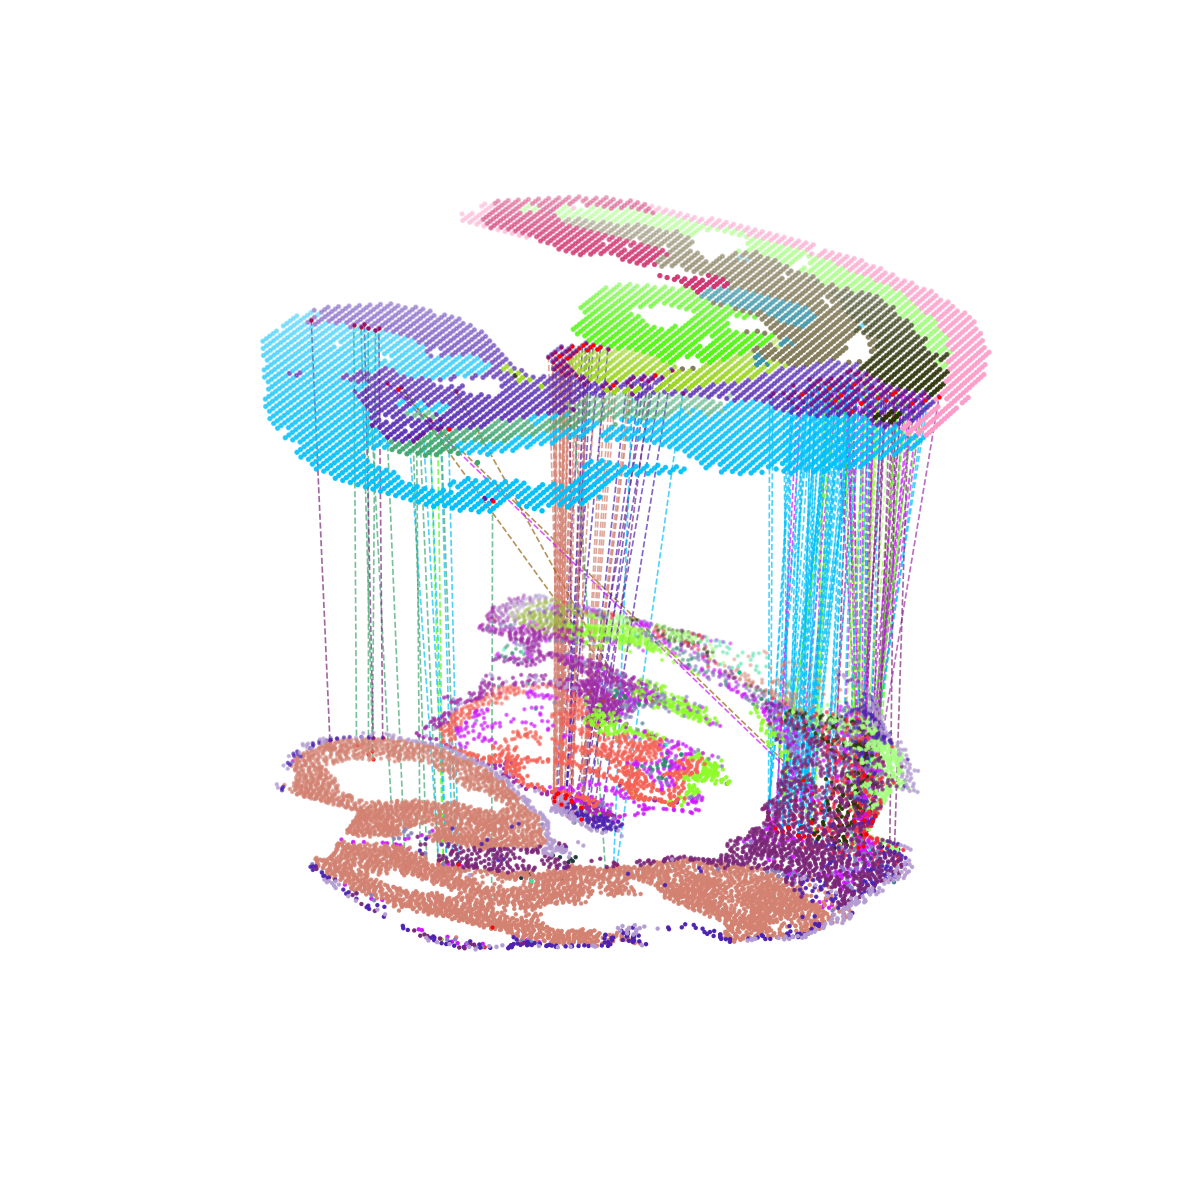

In [26]:
test = match_3D_celltype(adata1_df, adata2_df, matching[:, best_match > 0.7], meta='celltype', highlight_celltype=[list(set(adata1_df.celltype)),['Neural crest']],
                         subsample_size=3000, highlight_cell=['red'], scale_coordinate=True)
test.draw_3D(size=[10, 12], line_width=0.8, point_size=[1.25,2.5], hide_axis=True)

# Neural crest anno case

In [27]:
# adata2_df.celltype=='Neural crest' & adata2_df.target_celltype!='Low quality'
idx = np.where((adata2_df.celltype=='Neural crest') & (adata2_df.target_celltype!='Low quality') & (adata2.obs.low_quality_index > 0.7))

In [28]:
adata2.obs['target_celltype'] = adata1_df.iloc[matching[1,:],:]['celltype'].to_list()
neural_crest = adata2[idx[0],:]

In [22]:
sc.set_figure_params(dpi=200)

/rd2/user/xiacr/SLAT/scSLAT/model/preprocess.py:89: FutureWarning:

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.

/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



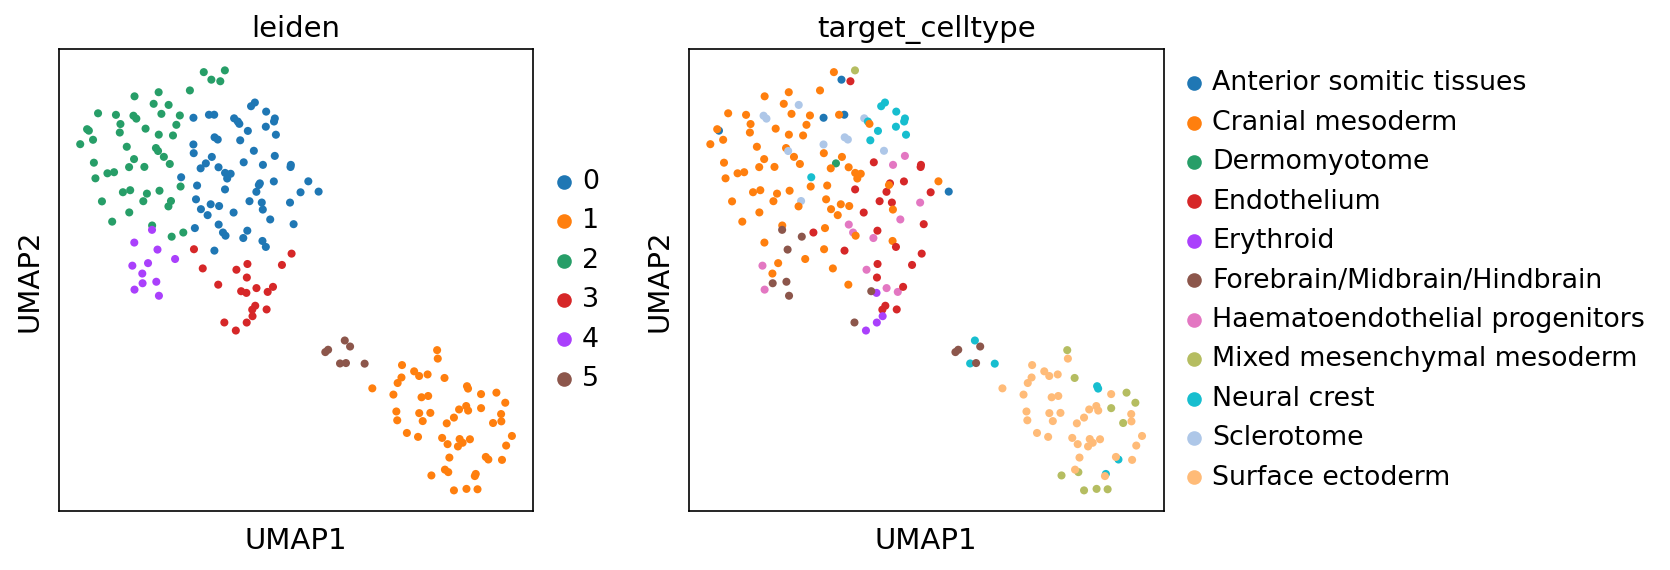

In [39]:
neural_crest = scanpy_workflow(neural_crest, n_comps=20)
sc.pp.neighbors(neural_crest, metric="cosine")
sc.tl.leiden(neural_crest, resolution=0.8)
sc.tl.umap(neural_crest)
sc.pl.umap(neural_crest, color=['leiden','target_celltype'], size=60)

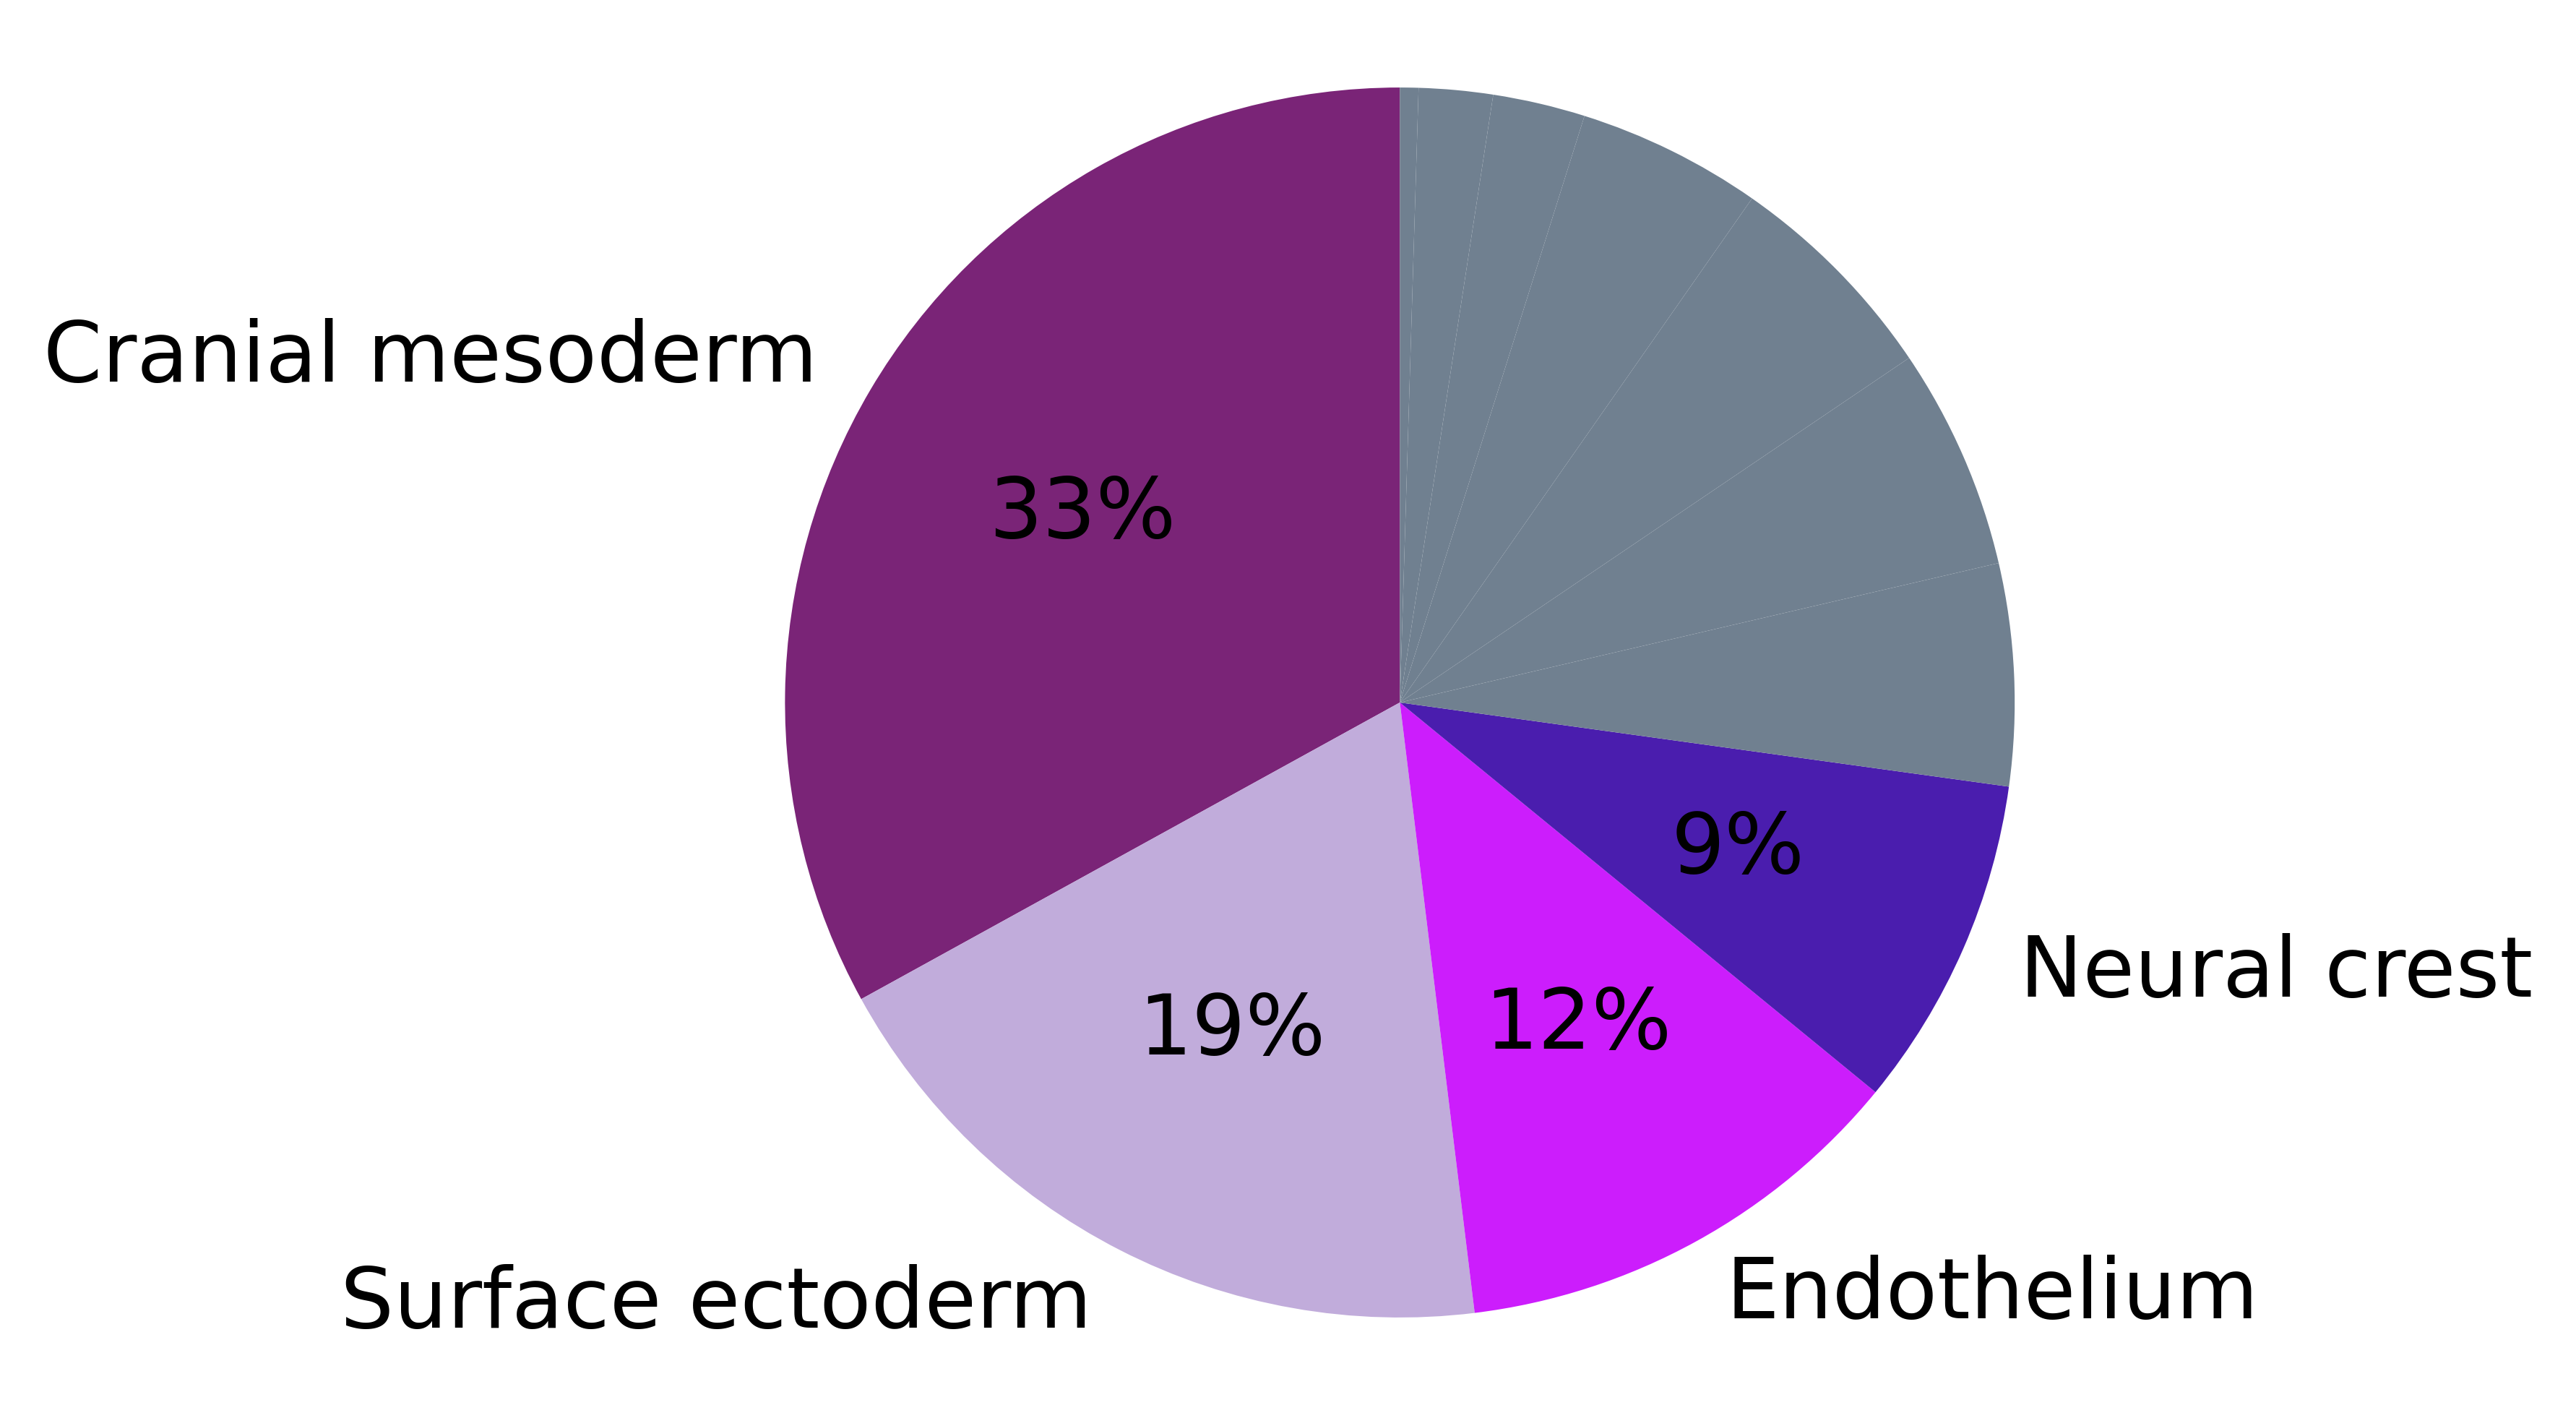

In [5]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels =  neural_crest.obs.target_celltype.value_counts().index.values
sizes = neural_crest.obs.target_celltype.value_counts().values
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
labels = [n if v > sizes.sum() * 0.06 else '' for n, v in zip(labels, sizes)]  

def autopct_more_than_1(pct):
    return ('%1.f%%' % pct) if pct > 6 else ''

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct=autopct_more_than_1,
        colors=["#7A2477","#C1ACDB","#CC1DFC","#4A1DAE","#708090","#708090","#708090","#708090","#708090","#708090","#708090"],
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [6]:
neural_crest.obs['target_celltype_main'] = neural_crest.obs['target_celltype'].tolist()
neural_crest.obs.loc[~adata2.obs.target_celltype.isin(labels), 'target_celltype_main'] = 'Other'

/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


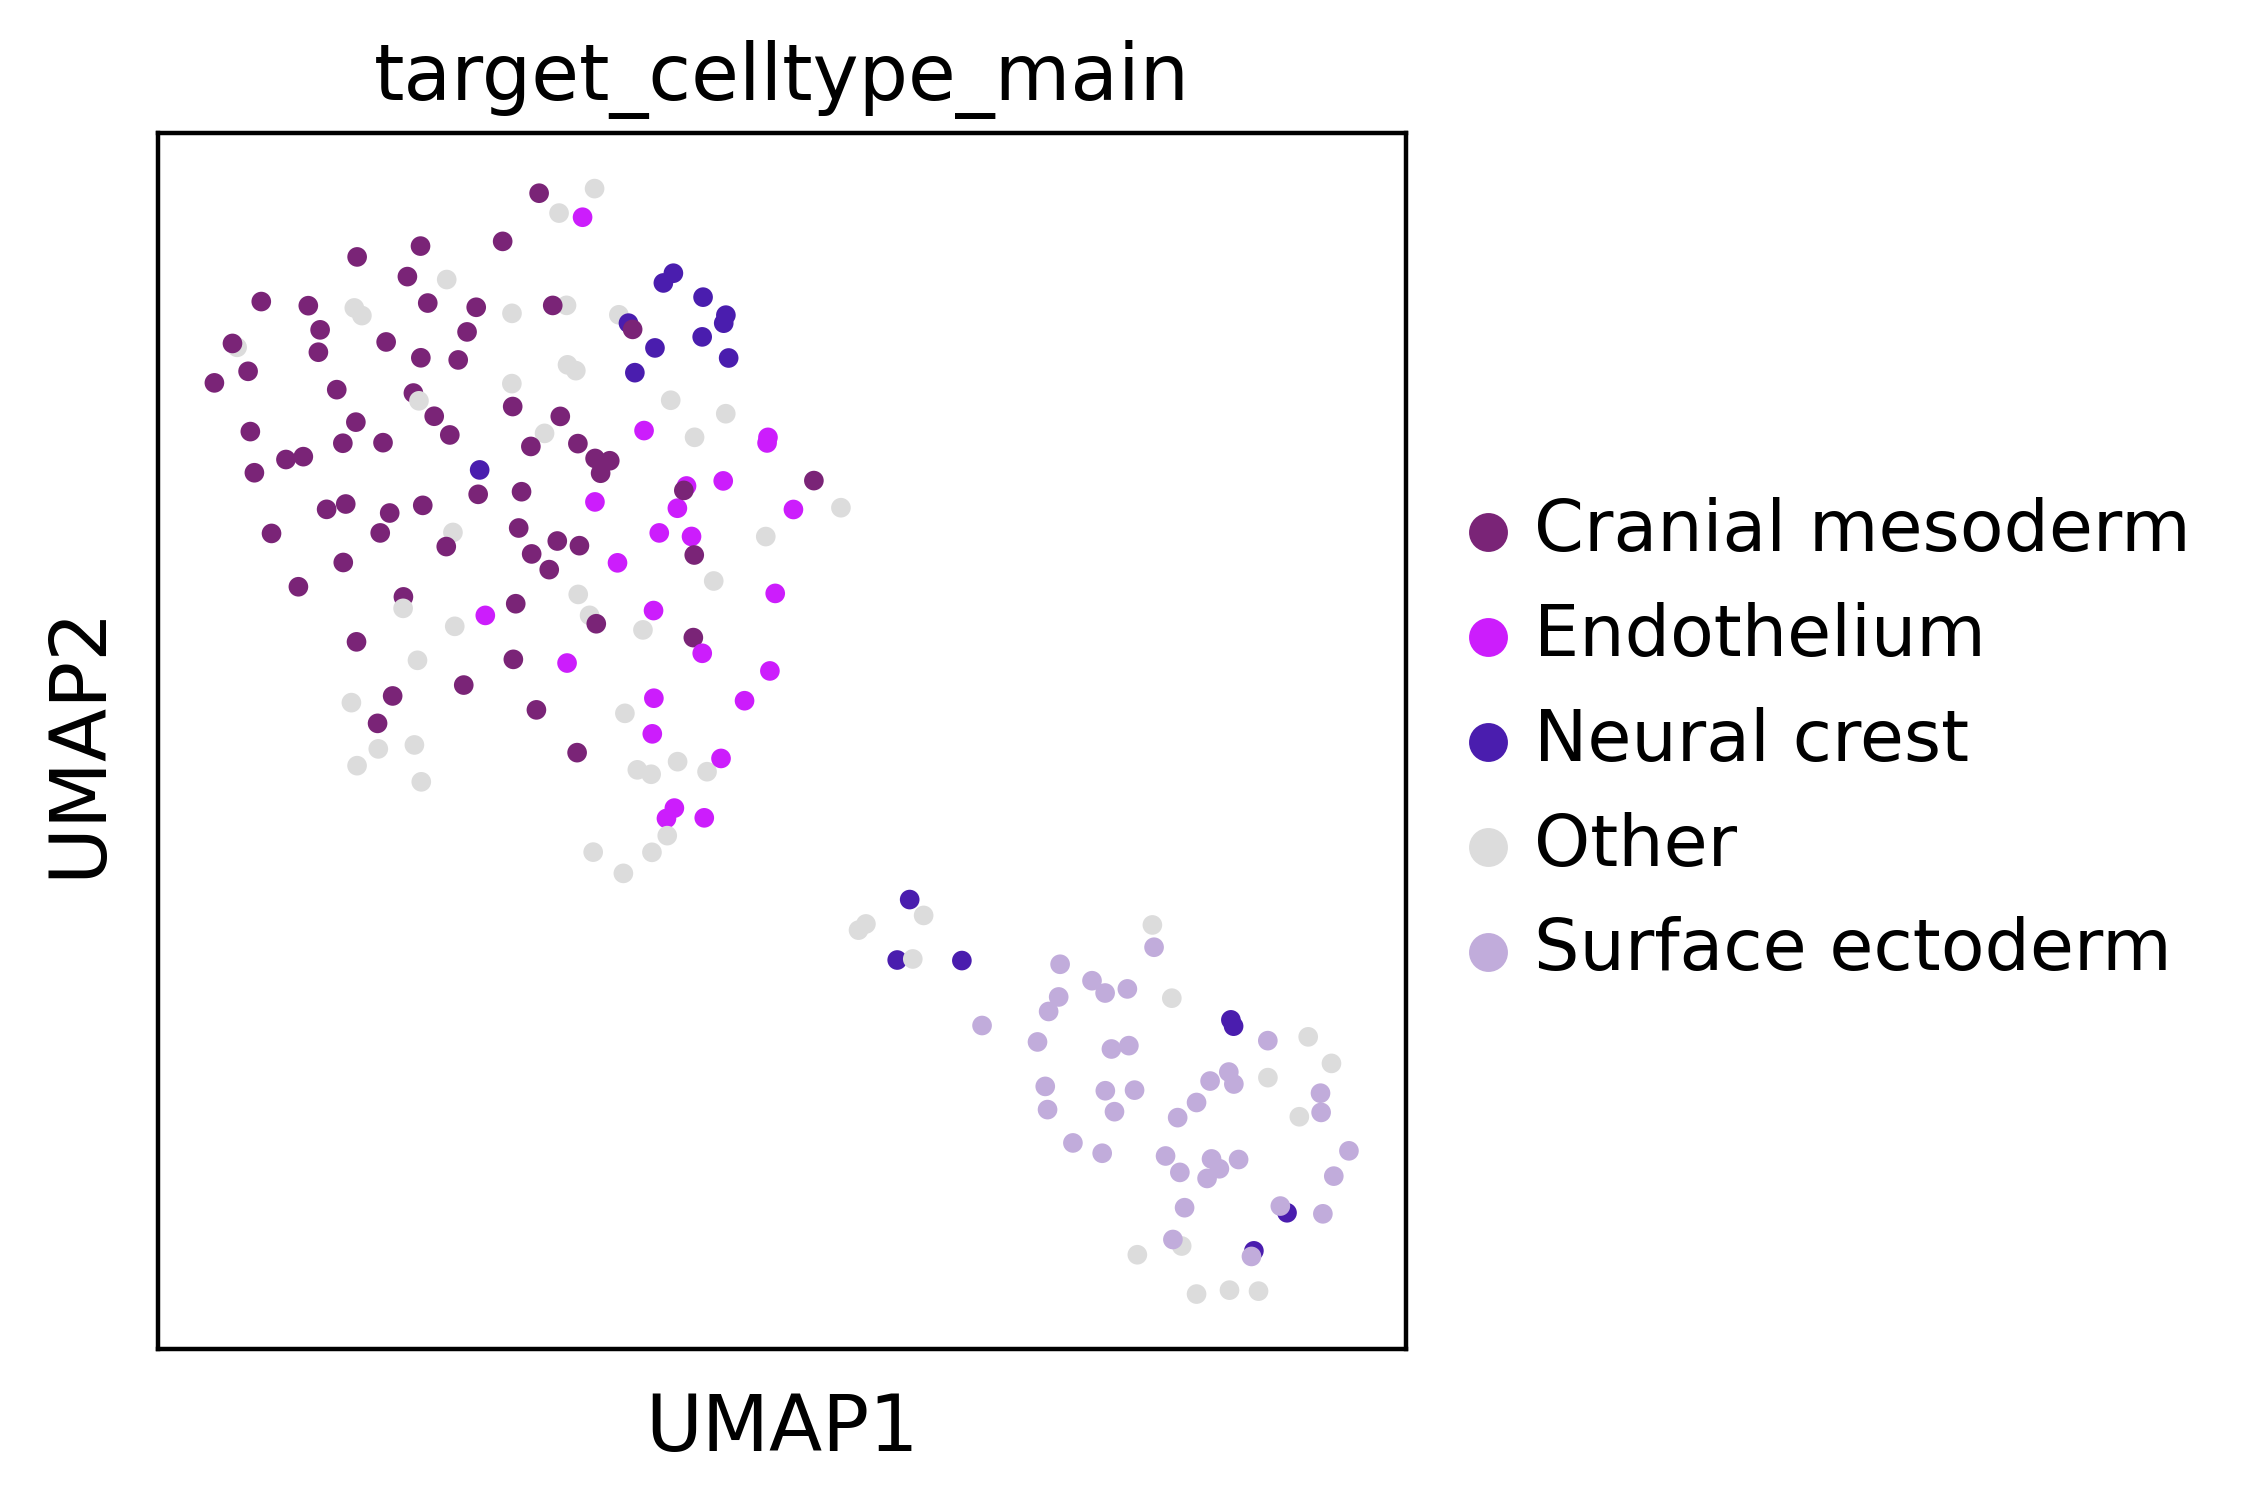

/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


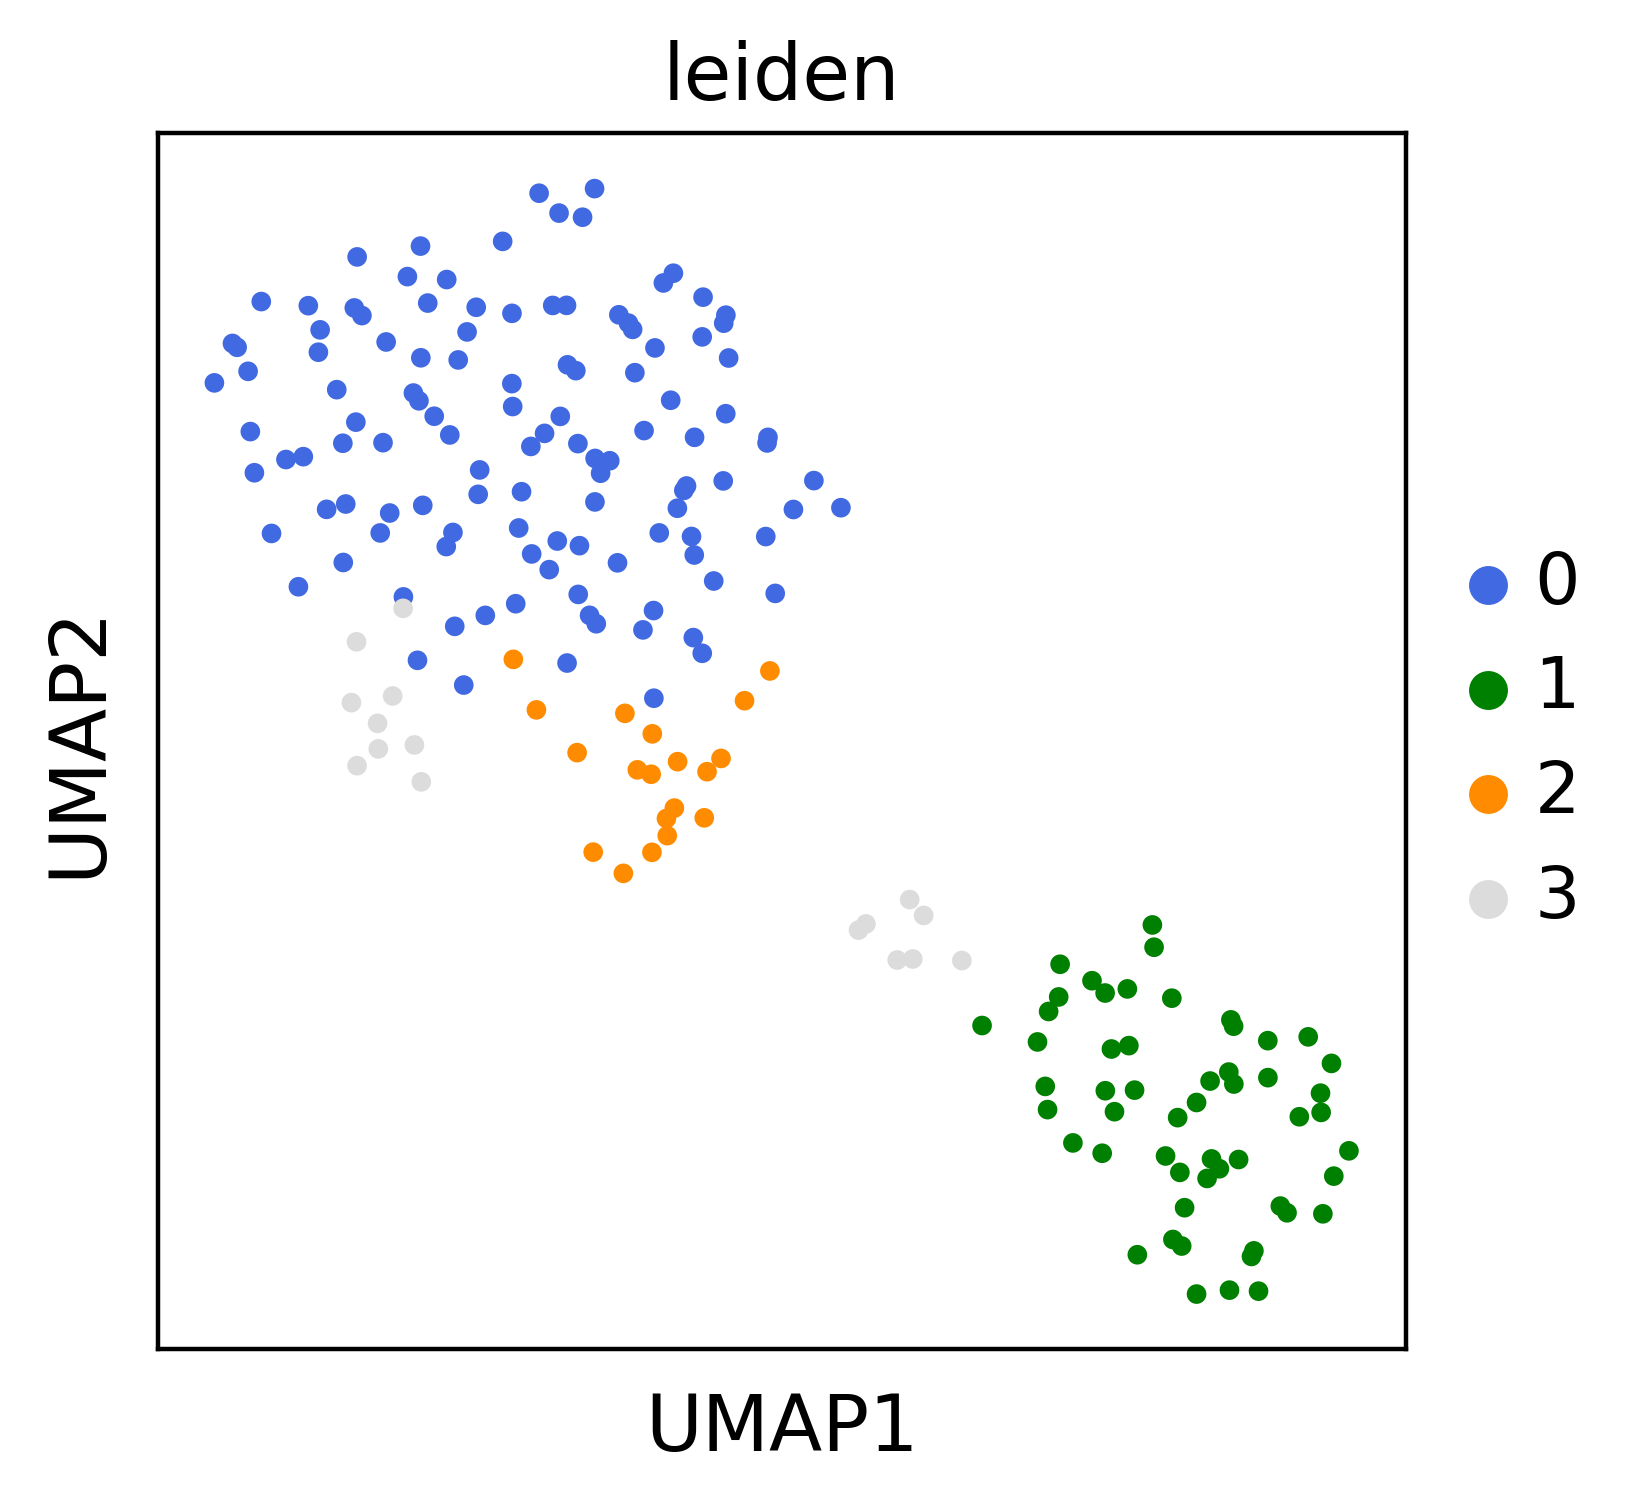

In [23]:
sc.pl.umap(neural_crest, color=['target_celltype_main'], size=50, wspace=0.9, palette=['#7A2477','#CC1DFC','#4A1DAE','#DCDCDC','#c1acdb','#FFD700','#DCDCDC','#DC143C','#DCDCDC'])
sc.pl.umap(neural_crest, color=['leiden'], size=50, wspace=0.9, palette=['#4169E1','green','#FF8C00','#DCDCDC','purple','#FFD700','#20B2AA','#DC143C'])

/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored



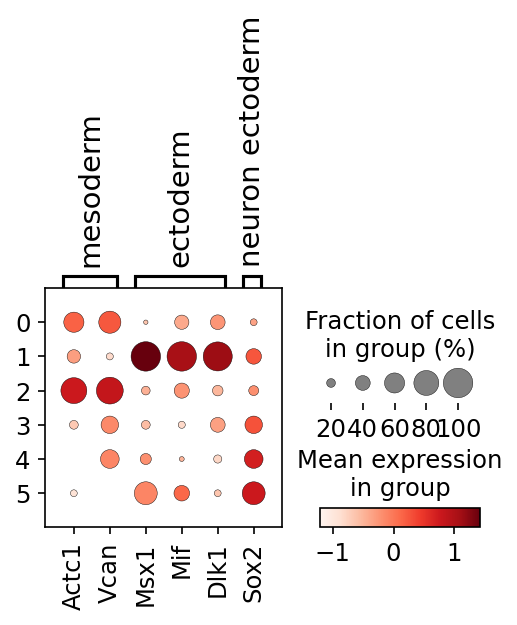

In [40]:
p = sc.pl.dotplot(neural_crest, 
              var_names={'mesoderm':['Actc1','Vcan'],
                        'ectoderm':['Msx1','Mif','Dlk1'],
                        'neuron ectoderm':['Sox2'],
                        },
              groupby='leiden')

In [41]:
# annotation
neural_crest.obs['re_anno'] = 'unknown'
neural_crest.obs.loc[neural_crest.obs.leiden.isin(['0','2','3','4']),'re_anno'] = 'Mesoderm'
neural_crest.obs.loc[neural_crest.obs.leiden.isin(['1','5']),'re_anno'] = 'Ectoderm'

/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


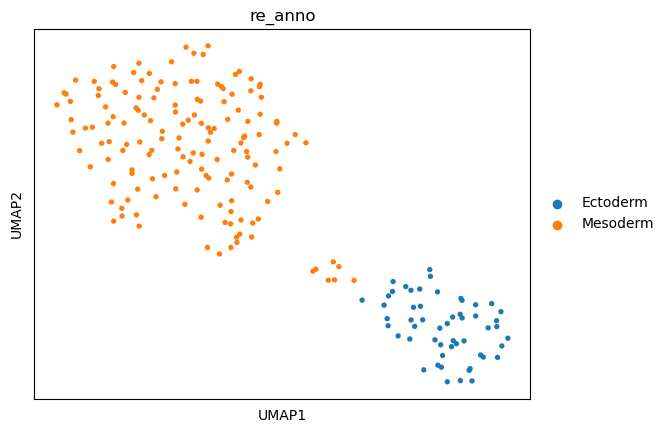

In [3]:
sc.pl.umap(neural_crest, color=['re_anno'], size=60)

/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


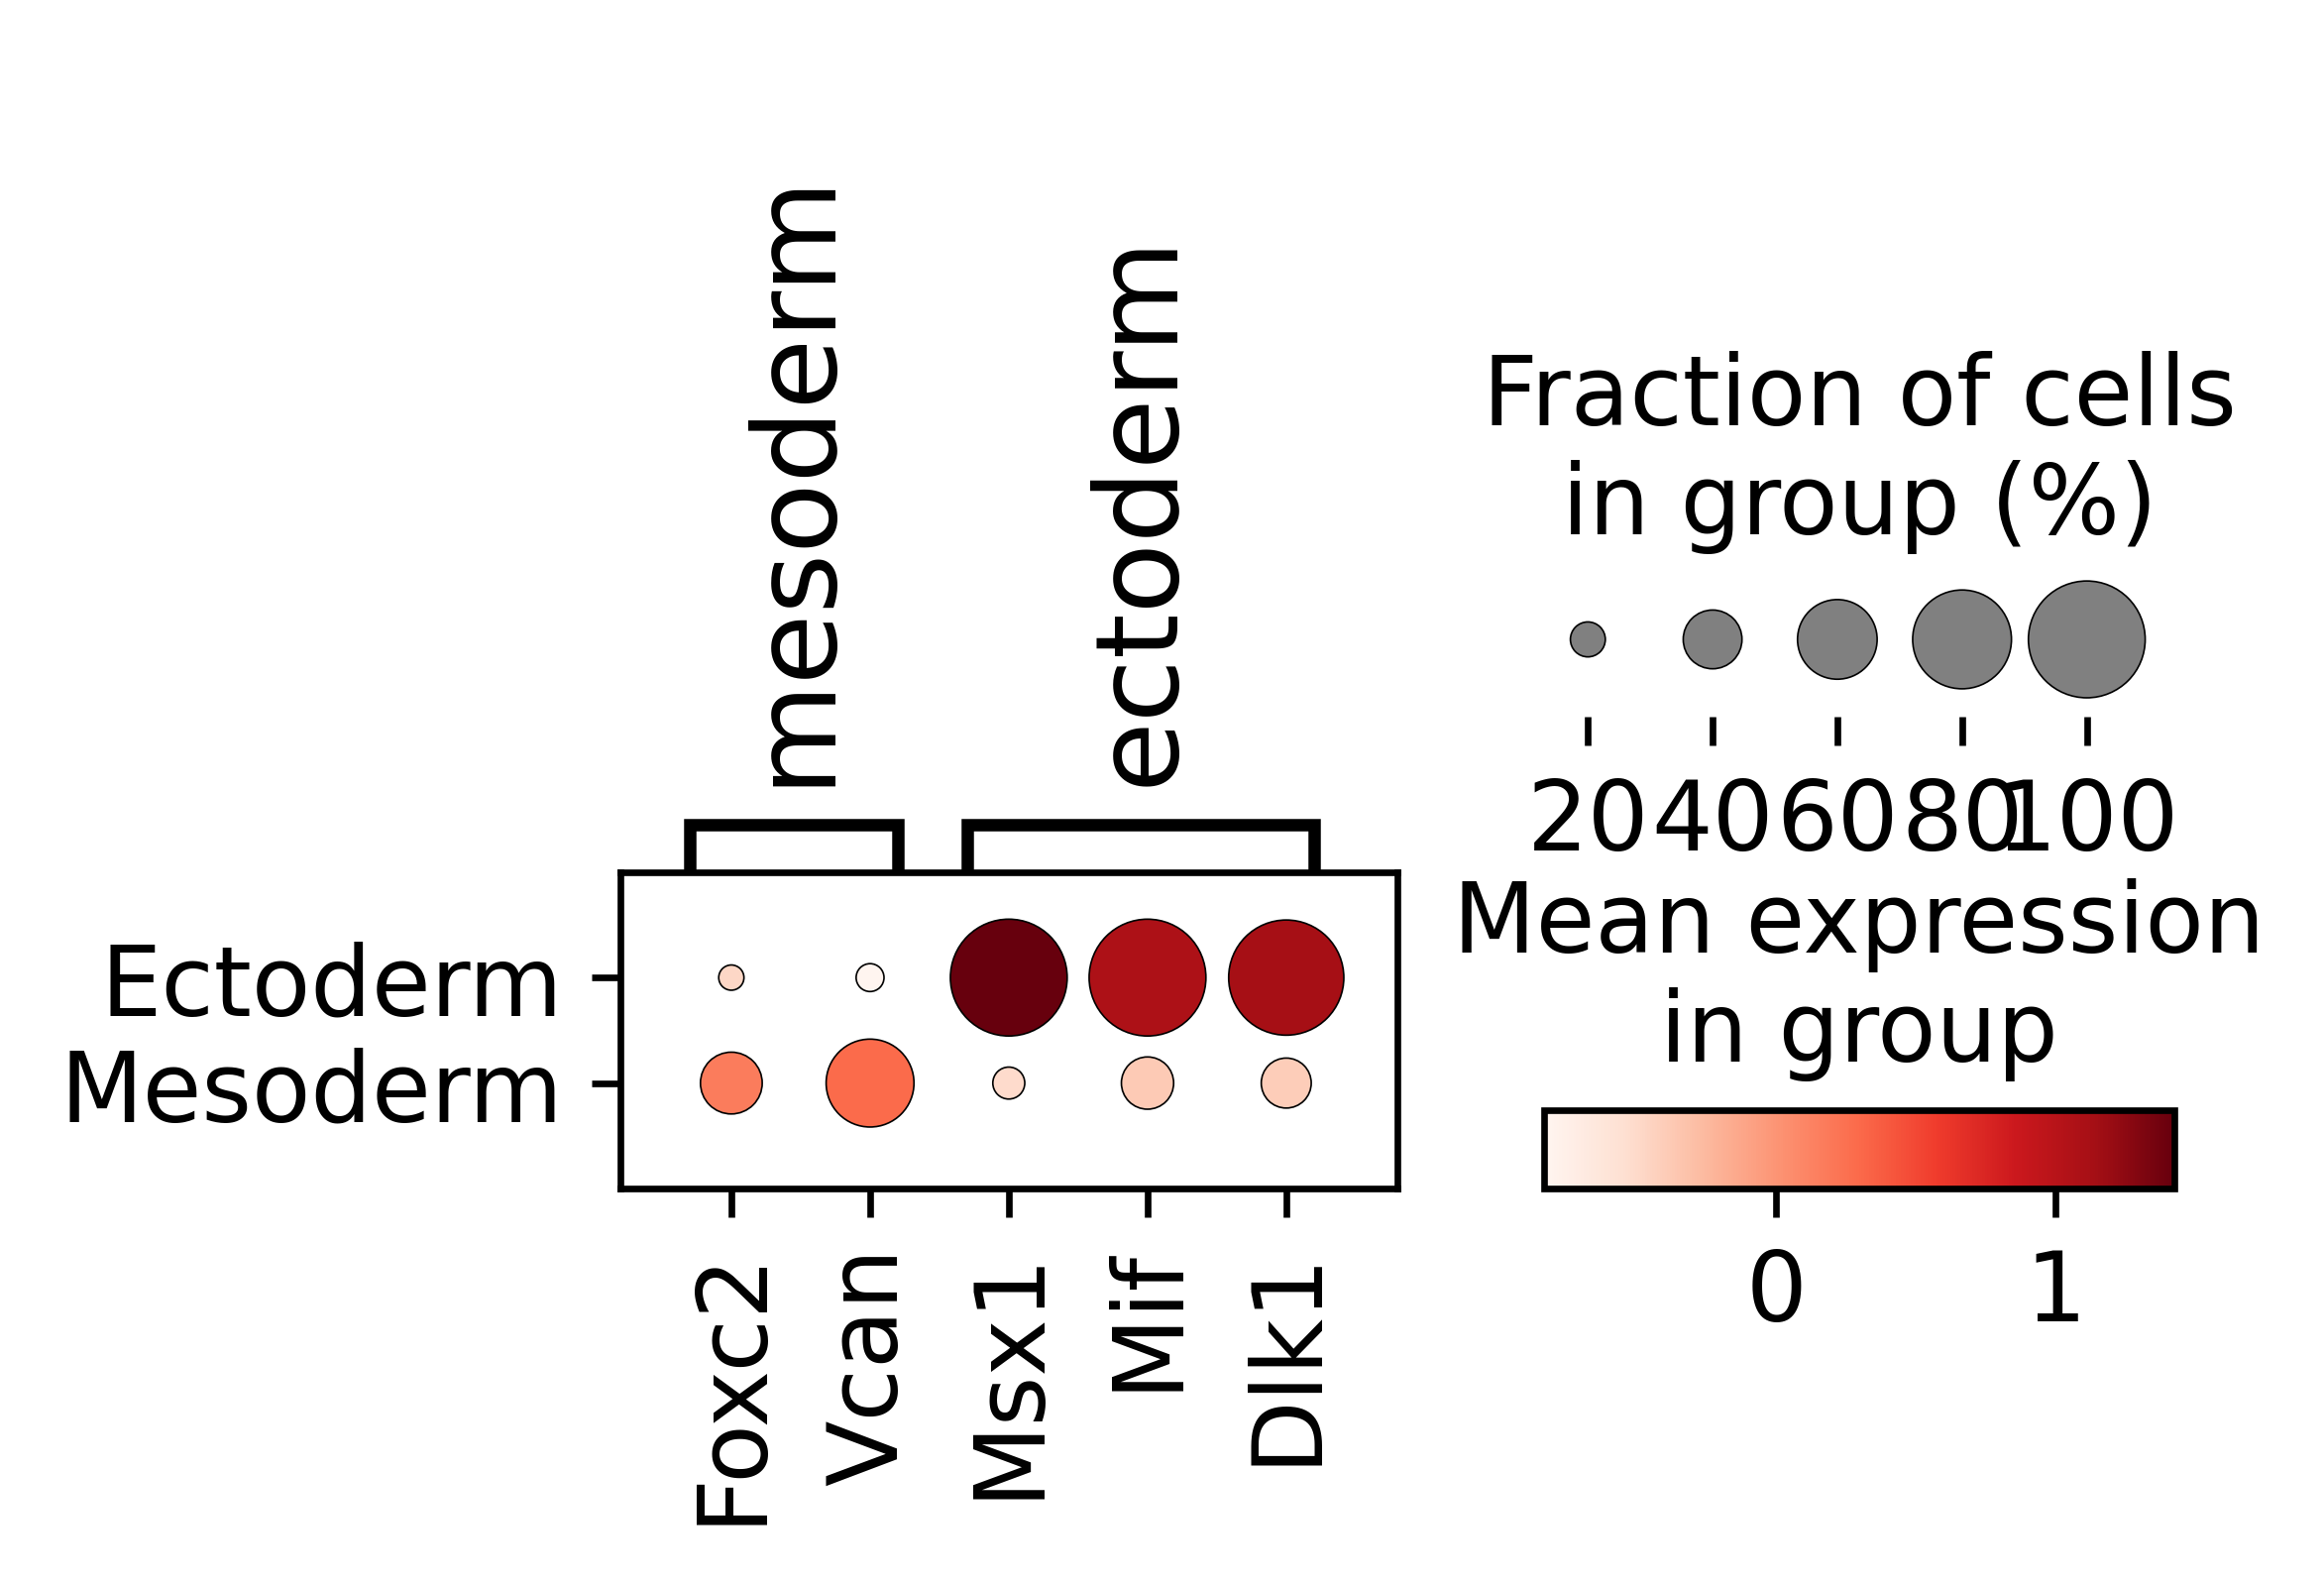

In [15]:
p = sc.pl.dotplot(neural_crest, 
              var_names={'mesoderm':['Foxc2','Vcan'],
                        'ectoderm':['Msx1','Mif','Dlk1'],
                        },
              groupby='re_anno')

/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


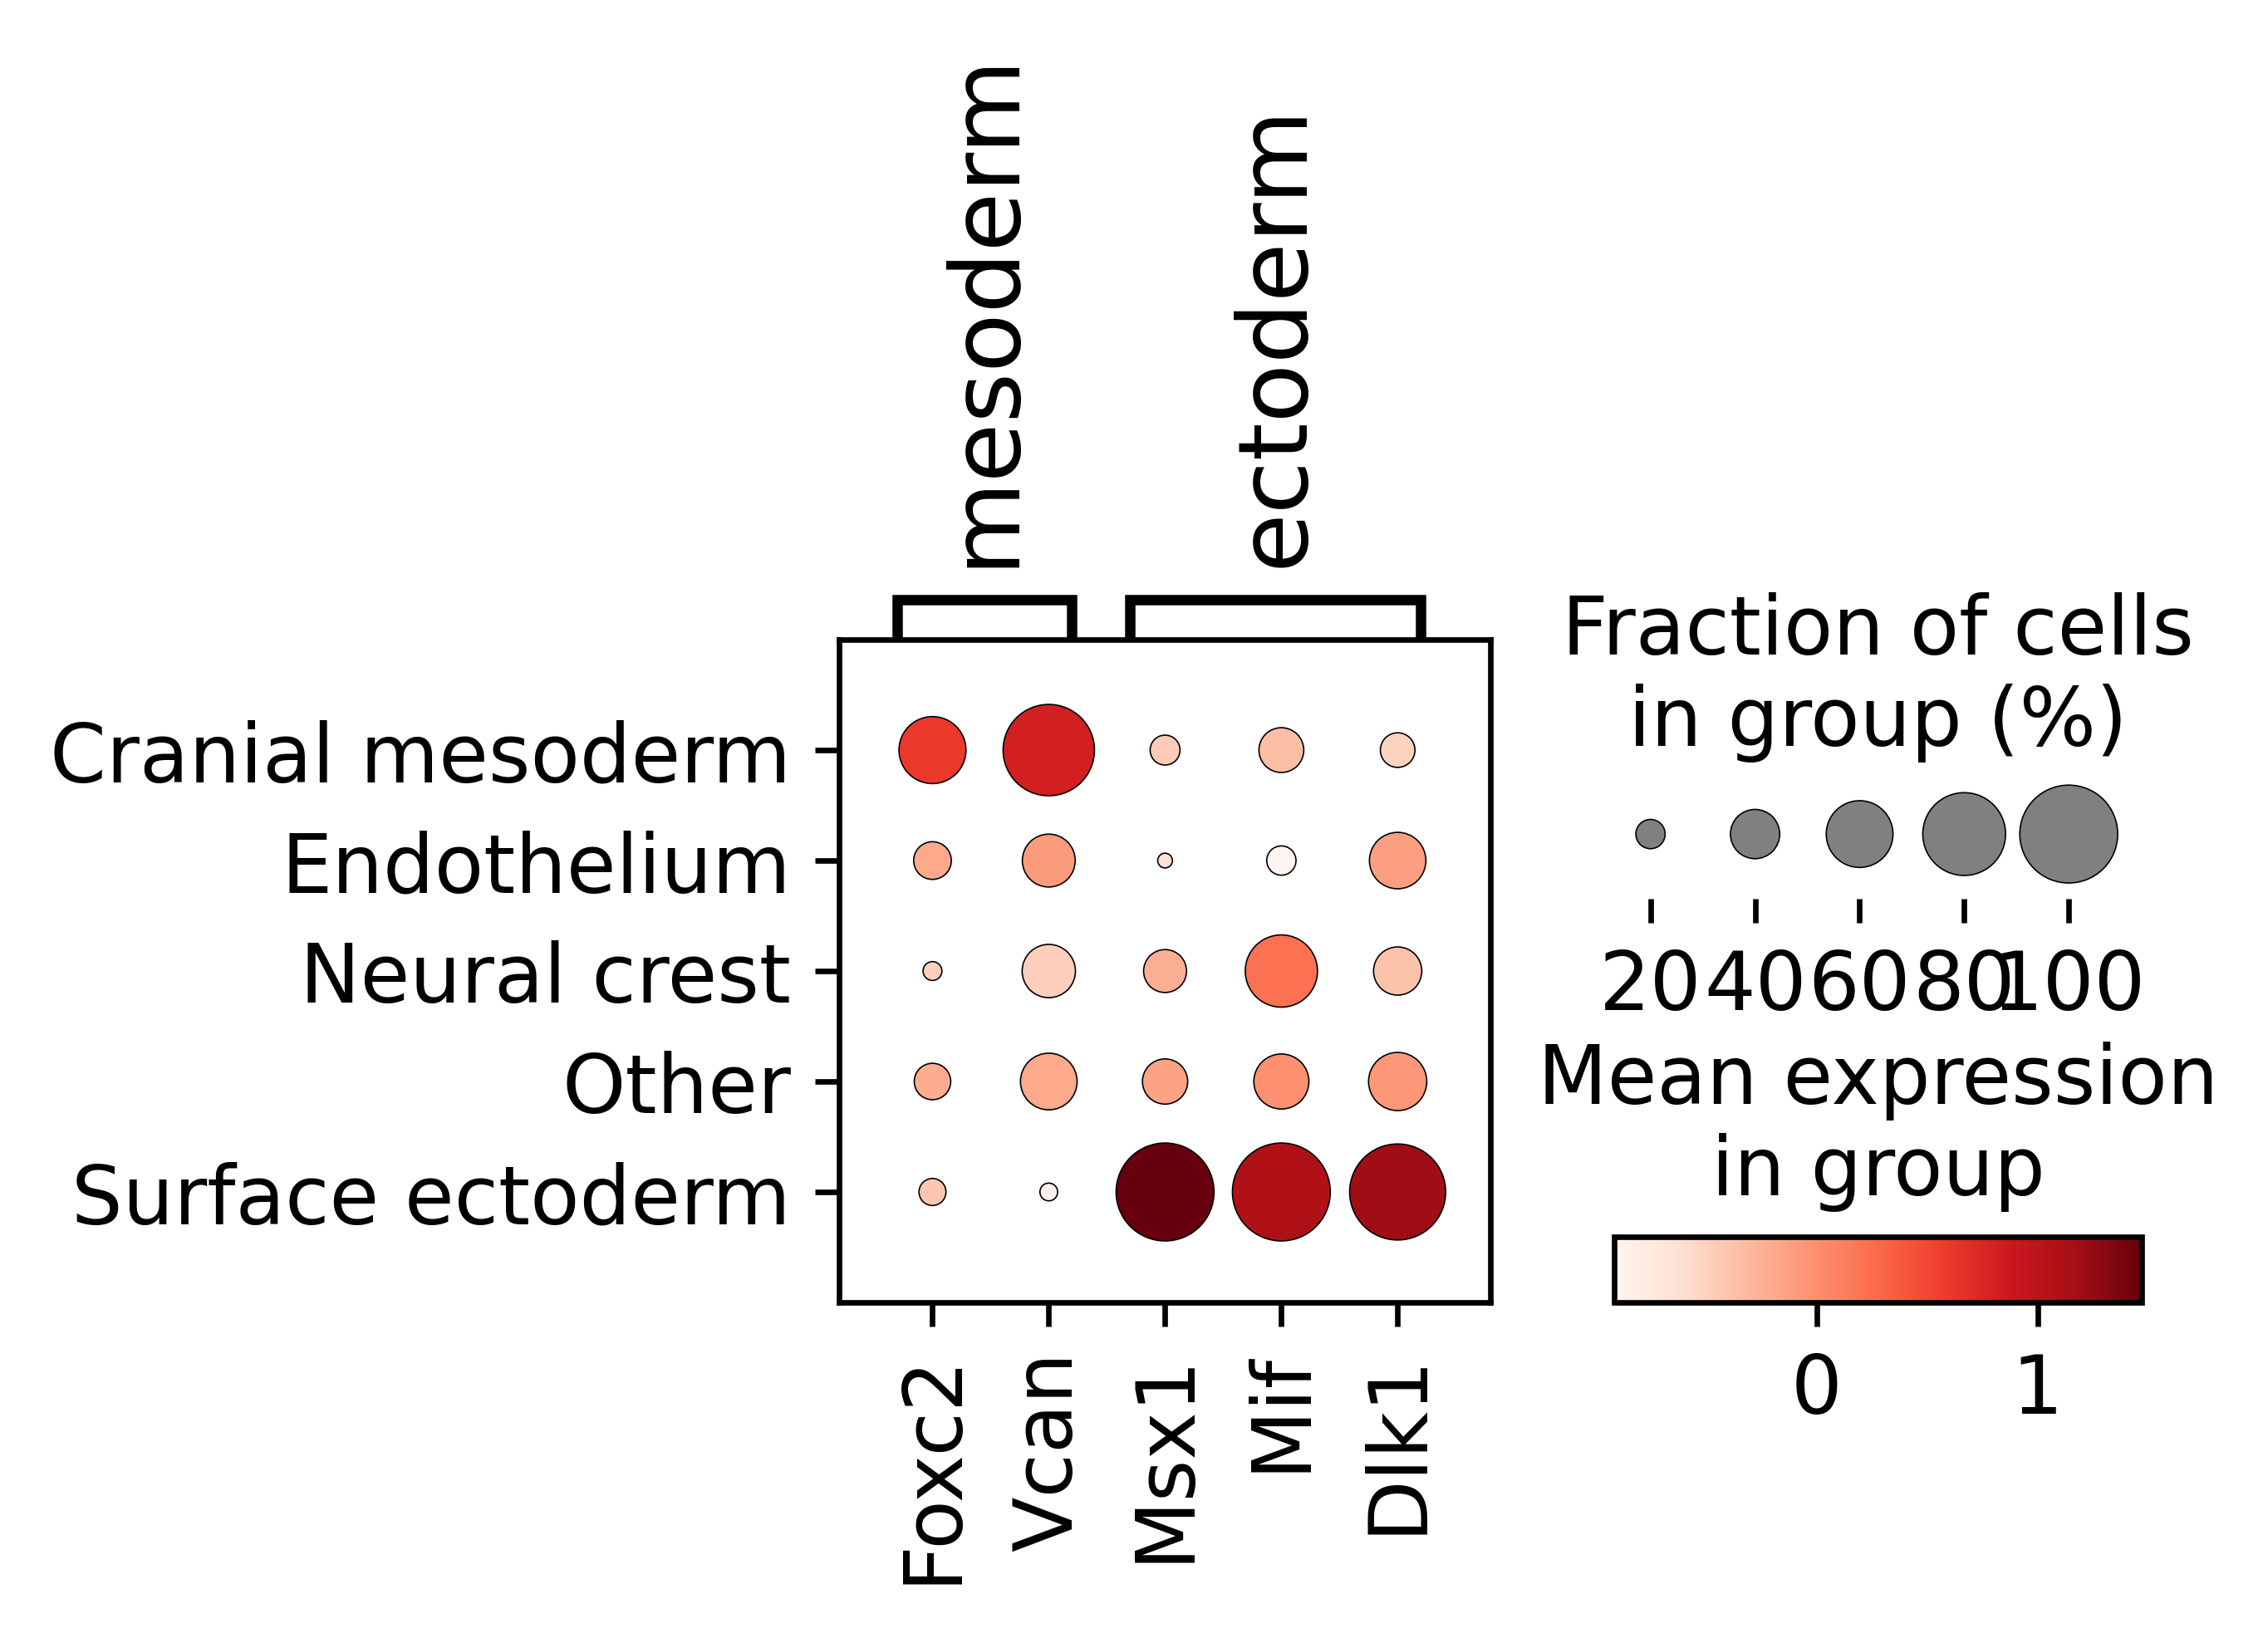

In [7]:
p = sc.pl.dotplot(neural_crest, 
              var_names={'mesoderm':['Foxc2','Vcan'],
                        'ectoderm':['Msx1','Mif','Dlk1'],
                        },
              groupby='target_celltype_main')

In [ ]:
adata2_df['target_celltype'] = adata1_df.iloc[matching[1,:],:]['celltype'].to_list()

In [36]:
neural_crest.write_h5ad('neural_crest.h5ad')
adata1_filter.write_h5ad('seqFISH_filer.h5ad')
adata2.write_h5ad('Stereo_filer.h5ad')

In [4]:
neural_crest = sc.read_h5ad('neural_crest.h5ad')
adata1_filter = sc.read_h5ad('seqFISH_filer.h5ad')
adata2 = sc.read_h5ad('Stereo_filer.h5ad')

In [37]:
np.savetxt('./SLAT_matching.csv', matching, delimiter=',')